# ELISA analyzer

##### Copy and paste OD values to the "ELISA Tamplet.xlsx" file, with standard curve duplicates in the lower table, tested samples in the upper left table, and samples' dilution factors on the upper right table,  as follows: 

In [1]:
#Options to insert image to jupyter in markdown cell(with or w/o controling image size):
#![](Capture.jpg)
#<img src="Capture.jpg"/>
#<img src="Capture.jpg" style="width:400px; height:200px"/>

![](Tamplet_image.jpg)

### Importing required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import leastsq
import math
%matplotlib inline

# Pandas version 0.24.0 or higher is required.
print(pd.__version__)

1.0.3


### Asking for input file and standard curve range

In [3]:
file_name = input("Enter file name (e.g. file.xlsx):")
if len(file_name)<1:
    file_name = "ELISA Tamplet.xlsx"
    
plate_num = input("How many plates whould you like to analyze?:")
if len(plate_num)<1:
    plate_num = 3
plate_num = int(plate_num)


#Asking for standard curve highest point (assigning a defult values if pressing Enter):  
high_std = input("Enter the highest std curve point:")
if high_std=='':
    high_std = 1600
high_std = float(high_std)

#Asking for standard curve dilution factor (assigning a defult values if pressing Enter):
dil_factor = input("Enter the dilution factor:")
if dil_factor=='':
    dil_factor = 2
dil_factor = float(dil_factor)

Enter file name (e.g. file.xlsx):
How many plates whould you like to analyze?:
Enter the highest std curve point:
Enter the dilution factor:


### Creating DataFrames of standard curve and samples' raw OD values  

In [4]:
'''
stdOD_sampleOD_dil_error_df_generator() function take the following arguments:
1. Excel file containing raw data (OD) of ELISA assay. 
2. Plate number - the plate to be analyzed (sheet number in the excel file). 

The functoin create and return several DataFrames, including: 
1. standard curve OD df
2. standard curve concentration df
3. Sample OD df
4. dilution factor df
5. Error df (for values outside the range of standard curve)
'''


def stdOD_sampleOD_dil_error_df_generator(file_name, plate_num): 
    OD_df = pd.read_excel(file_name, sheet_name='Plate {}'.format(plate_num))
    #display(OD_df)

    # Extracting the std curve ODs:
    std_OD_df = OD_df.iloc[12:,1:3].reset_index().drop("index",1)
    std_conc_df = OD_df.iloc[12:,3:4].reset_index().drop("index",1)

    #Extracting samples' ODs, subtracting the blank OD from each point, and changing columns names using list comprehension:
    sample_df = OD_df.iloc[1:9,1:13]
    sample_df.columns = [n for n in range(1,13)]
    
    sample_MinusBlank_df = OD_df.iloc[1:9,1:13] - std_OD_df.mean(axis=1).iloc[-1]
    sample_MinusBlank_df.columns = [n for n in range(1,13)]

    # Extracting the samples' dilution factors:
    sample_dil_df = OD_df.iloc[1:9,15:27]
    sample_dil_df.columns = [n for n in range(1,13)]
    
    # Creating an Error DataFrame for indicating values below or above the standard curve:     
    sample_df_array = np.asanyarray(sample_df).reshape(96)
    std_average_array = np.asanyarray(std_OD_df.mean(axis=1))
    error_list = list()

    i=0
    for OD in sample_df_array:
        if OD>np.max(std_average_array):
            error_list.append("^ULOQ")
        elif OD<np.min(std_average_array):
            error_list.append("vLLOQ")
        else:
            error_list.append("-")
        i+=1
        
    error_array = np.array(error_list).reshape([8,12])
    error_df = pd.DataFrame(data=error_array, index=None, columns=[n for n in range(1,13)], dtype=None, copy=False)
    
    return std_OD_df, std_conc_df, sample_df, sample_MinusBlank_df, sample_dil_df, error_df 



#running the function and assigning its dataframes output to variables: 
#std_OD_df, std_conc_df, sample_df, sample_MinusBlank_df, sample_dil_df, error_df = stdOD_sampleOD_dil_error_df_generator(file_name, plate_num) 

#display("Standard curve duplicates' OD table:", std_OD_df)
#display("Standard curve duplicates' concentration table:", std_conc_df)
# display("Samples' OD table:",sample_df)
# display("Samples' OD minus blank table:",sample_MinusBlank_df)
# display("Samples' dilution table:",sample_dil_df)
#display("Error table (values below or above standard curve range):",error_df)

### Creating a standard curve DataFrame (including concentratoin and OD) 

In [5]:
'''
1. std_curve_df_generator() function generate a DataFrame of standard curve ODs and concentratoins.
2. The function takes as an argument a DataFrame of standard vurve ODs,calculate the average of std duplicates,
and subtract the blank OD from all std curve points.
3. Then, it askes for the highest std curve concentration and dilution factor, and calculate the std curve's 
concentration range. 
4. Finally, it addes the ODs and concentrations to a the DataFrame std_conc_od_df, and returns it. 
'''

def std_curve_df_generator(std_OD_df, high_std, dil_factor):
#calculating the average of duplicates of each std curve point and subtracting the blank from it.  
    std_OD_df = std_OD_df
    std_OD_average_df = std_OD_df.mean(axis=1)
    std_OD_average_MinusBlank_df = std_OD_average_df-std_OD_average_df.iloc[-1]          
        
#Calculating the standard curve concentration range using the arguments high_std and dil_factor: 
    #Calculating standard curve range vlues and adding them into np.array:       
    std_conc_array = np.zeros((8,1))
    std_conc_array[0] = high_std
    std_conc_array[7] = 0
    std = high_std
    for i in range(1,7):
        std = std/dil_factor
        std_conc_array[i] = std
    
#Creating a DataFrame of standard curve ODs and concentrations: 
    #First,make sure that the OD and concentration are in 1 dimentional (shape (n,) np.array:  
    std_OD_average_MinusBlank_array = np.array(std_OD_average_MinusBlank_df)
    std_conc_array = std_conc_array.reshape(8,)
    
    #Create the DataFrame:
    std_conc_od_df = pd.DataFrame({'Conc.':std_conc_array, 'OD':std_OD_average_MinusBlank_array}, index = [0,1,2,3,4,5,6,7])
    
#Displaying std curve table and plot:
    #display(std_conc_od_df)
    #std_conc_od_df.plot('Conc.', 'OD', kind='scatter')
    #sns.lmplot(x='Conc.', y='OD', data=std_conc_od_df)
    
    return std_conc_od_df

    
# std_conc_od_df = std_curve_df_generator(std_OD_df, high_std, dil_factor)
# display(std_conc_od_df)

### Standard curve fit using 4 Parameters Logistic (4PL) regression modeling

In [6]:
'''
1. std_curve_curvefit_4PL() function generates a 4PL model according to 
   std curve concentrations (X) and ODs (y).
2. The function takes as an argument a std_conc_od_df DataFrame of ODs and concentrations, 
   generated by the std_curve_df_generator() function.
3. The function returns the calculated parameters of the 4PL model (A,B,C,D), array of std curve concentration 
   (X; w/o the blank), array of std curve ODs (y; w/o the blank), and the predicted std curve points (std_fit_array).) 
'''

def std_curve_curvefit_4PL(std_conc_od_df):    
#Creating a 4PL regresion model. 
    #Setting the X and y data sets (excluding the last value of the blank):
    X = np.asanyarray(std_conc_od_df[["Conc."]])[:-1].reshape(7)
    y = np.asanyarray(std_conc_od_df[["OD"]])[:-1].reshape(7)
    
    #Fitting the 4PL model and creating the predictor (std_fit):
    def logistic4(X, A, B, C, D):
        """4PL lgoistic equation."""
        return ((A-D)/(1.0+((X/C)**B))) + D

    def residuals(p, y, X):
        """Deviations of data from fitted 4PL curve"""
        A,B,C,D = p
        err = y-logistic4(X, A, B, C, D)
        return err

    def peval(X, p):
        """Evaluated value at x with current parameters."""
        A,B,C,D = p
        return logistic4(X, A, B, C, D)

    # Initial guess for parameters
    p0 = [0, 1, 1, 1]

    # Fit equation using least squares optimization
    plsq = leastsq(residuals, p0, args=(y, X))
    print(plsq)
    
    A_calc = plsq[0][0]
    B_calc = plsq[0][1]
    C_calc = plsq[0][2]
    D_calc = plsq[0][3]
    
    # calculating predicted ODs using the 4PL parameters
    std_fit_list = list()
    for n in X:
        std_fit = logistic4(n, A_calc, B_calc, C_calc, D_calc)
        std_fit_list.append(std_fit)

    std_fit_array = np.array(std_fit_list)
    #display(std_fit_array)
    
    return (A_calc, B_calc, C_calc, D_calc, X, y, std_fit_array)


#Running the function:
#std_OD_df = stdOD_sampleOD_dil_error_df_generator(file_name, plate_num)[0]
#std_conc_od_df = std_curve_df_generator(std_OD_df, high_std, dil_factor)

#display(std_conc_od_df)
#std_curve_curvefit_4PL(std_conc_od_df)

### Creating a figure of standard curve plot and saving it

In [7]:
'''
1. std_curve_4PL_vis() function plot the std curve fit.
2. Takes as an argument the function std_curve_curvefit_4PL, wich returns the calculated parameters of the 4PL model 
   (A,B,C,D), array of std curve concentration (X; w/o the blank), array of std curve ODs (y; w/o the blank), 
   and the predicted std curve points (std_fit_array), and plate number (for inserting to figure title and file name). 
3. The function plot the data and save the image in the folder where the script is located. 
'''

def std_curve_4PL_vis(std_curve_curvefit_4PL, plate_num):
    A_calc, B_calc, C_calc, D_calc, X, y, std_fit_array = std_curve_curvefit_4PL    
    #Plotting std curve points scatter and a plot of the std curve model: 
    plt.scatter(X,y)
    plt.plot(X,std_fit_array,color='blue')
    plt.title("Standard curve - plate {}".format(plate_num))
    plt.xlabel('Concentration')
    plt.ylabel('OD')
    plt.savefig('Std_curve-plate {}.png'.format(plate_num))
    plt.show()
    
#std_curve_4PL_vis(std_curve_curvefit_4PL(std_conc_od_df),2)

### Creating a DataFrame with std curve details (R^2, and parameters A,B,C,D)

In [8]:
'''
1. std_curve_4PL_details() function prints out the attributes of a 4PL model generated according to 
   std curve concentrations (X) and ODs (y).
2. Takes as an argument the function std_curve_curvefit_4PL, wich returns the calculated parameters of the 4PL model (A,B,C,D), array of std curve concentration 
   (X; w/o the blank), array of std curve ODs (y; w/o the blank), and the predicted std curve points (std_fit_array). 
3. The function return a DataFrame with the parameters of the model (A,B,C,D and R^2). 
'''

def std_curve_4PL_details(std_curve_curvefit_4PL):
    #Assigning model parameters:
    A_calc, B_calc, C_calc, D_calc, X, y, std_fit_array = std_curve_curvefit_4PL
    
    #Calculating the R2:
    R2 = r2_score(std_fit_array, y)
    std_curve_details_df = pd.DataFrame([{'R^2':R2, 'A':A_calc, 'B':B_calc, 'C':C_calc, 'D':D_calc}])
    
    return std_curve_details_df
    
#std_curve_4PL_details(std_curve_curvefit_4PL(std_conc_od_df))

### Calculating samples' concentration using the standard curve (4PL)

In [9]:
'''
1. sample_concentration_predict() function calculate the concentration of samples (x) according to OD values (y) and 
   a 4PL model fitted by the std_curve_curvefit_4PL() function. 
2. The function takes as arguments a 4PL model and samples OD DataFrame (sample_MinusBlank_df).
3. The function calculate the concentration of samples (x) according to x = ((((A-D)/(Y-D))-1)**(1/B))*C equation, 
   and then multiply the values by the dilution factor.
4. Returns a DataFrame of samples concentrations.  
'''

def sample_concentration_predict(model, sample_MinusBlank_df):
      
    #setting the variables (x-empty array, y-OD values) and parameters of the linear model(A, B, C, D ):
    y = np.asanyarray(sample_MinusBlank_df).reshape(96)
    x_array = np.zeros(96)
    
    # In our case, the model's parameters A-D are the 4 first items in the tuple return by std_curve_curvefit_4PL function:   
    A = model[0]
    B = model[1]
    C = model[2]
    D = model[3]
    
    #Reshaping the sample_dil_df (dilution factors DataFrame) as one dimentional 96 rows array:   
    sample_dil_array = np.asanyarray(sample_dil_df).reshape(96)

    #Looping over the y (samples ODs), calculating the x values (concentration), and appending the results 
    #to the x_array: 
    i=0
    for Y in y:
        x = ((((A-D)/(Y-D))-1)**(1/B))*C
        x_array[i] = x
        i+=1     
        
    #Multiplying the x_array (calculated concentrations) by the sample_dil_df DataFrame to get fianl conc.: 
    x_sample_multiply_dil_array = x_array*sample_dil_array
    
    #Reshaping the conc. array and creating a DataFrame:  
    x_sample_multiply_dil_array = x_sample_multiply_dil_array.reshape([8,12])
    x_conc_df = pd.DataFrame(data=x_sample_multiply_dil_array, index=None, columns=[1,2,3,4,5,6,7,8,9,10,11,12], dtype=None, copy=False)
    
    return x_conc_df
    
    
#Running the function:
# the model in our case is the 4PL_model returned by std_curve_curvefit_4PL() function.
#display(sample_concentration_predict(std_curve_curvefit_4PL(std_conc_od_df), sample_MinusBlank_df))


### Calculating samples concentration using the above functions 
### and preparing lists of DataFrames for exporting data to excel 

(array([-1.67744977e-03,  1.01988769e+00,  2.53163382e+04,  3.07530542e+01]), 1)


Plate: 1
********
(array([-1.67744977e-03,  1.01988769e+00,  2.53163382e+04,  3.07530542e+01]), 1)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


,1,2,3,4,5,6,7,8,9,10,11,12
A,1531.601452,1668.945957,251.833896,1458.628750,6123.206580,9653.682387,12630.279434,11634.593992,9552.540387,14780.500751,13480.831438,10055.230110
B,783.698739,814.301083,284.346492,1706.078953,7554.467100,12176.308581,10712.004705,13301.554842,12873.899371,12020.523856,13735.627708,11676.759734
C,392.595303,412.445122,265.618505,1088.741979,4606.643618,13972.305442,12250.924585,10655.074923,13558.078393,16649.137267,11110.265264,14327.207711
D,199.491823,196.516765,329.982331,1182.672144,4467.432141,9151.842217,13341.024946,12406.652284,10340.806128,18399.991950,13341.252325,11898.118287
E,97.994437,101.351990,389.215160,5167.256552,5717.426005,10097.457321,8975.212647,13439.692313,14614.120184,11929.293641,14366.632995,15995.374178
F,49.317249,50.600672,318.446178,5144.650839,9407.326161,10909.947685,10402.258680,9701.990531,15706.156162,15361.448565,11394.219033,19381.725256
G,25.356923,26.098780,1086.035914,5577.255875,11971.936730,8417.038071,11444.280173,11511.343497,9851.662992,18144.625233,14023.023064,11018.709739
H,1.231084,2.111049,1132.795937,5719.967252,11820.049550,10840.025201,9589.882147,13005.470713,11281.071690,10478.683799,14879.014835,14555.649910


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


(array([-1.67744977e-03,  1.01988769e+00,  2.53163382e+04,  3.07530542e+01]), 1)


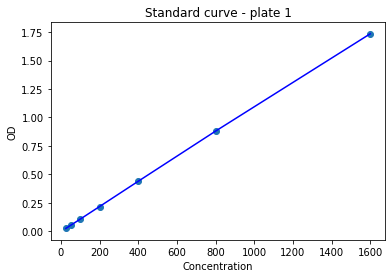

(array([-1.67744977e-03,  1.01988769e+00,  2.53163382e+04,  3.07530542e+01]), 1)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


,R^2,A,B,C,D
0,0.999994,-0.001677,1.019888,25316.338152,30.753054


(array([-3.78793334e-03,  9.98603953e-01,  3.66448131e+06,  4.51679584e+03]), 2)


Plate: 2
********
(array([-3.78793334e-03,  9.98603953e-01,  3.66448131e+06,  4.51679584e+03]), 2)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


,1,2,3,4,5,6,7,8,9,10,11,12
A,1585.286951,1615.613482,14720.656285,12840.068503,10043.141572,14513.245498,13079.764325,10505.109972,8166.158551,2025.945916,322.499179,6256.108028
B,772.981797,823.668847,8307.230319,15705.913801,15116.007189,10587.661135,14858.932475,16207.967535,10590.602125,2208.598387,1351.888017,8638.655423
C,389.881344,412.667646,13154.851212,9540.197557,16829.561190,14015.510530,9661.825401,16812.273471,10155.129440,3287.632294,1295.859108,3446.352109
D,195.257453,205.195647,12992.366882,13712.248130,4680.783845,15705.913801,14497.863857,10257.465695,15156.447922,284.105810,802.340206,3467.728228
E,97.286515,105.373198,9594.253943,18091.632135,5442.713395,4728.015236,15619.484070,13972.186678,17019.727782,230.847500,844.121797,4495.255280
F,47.910825,49.910387,13036.445281,10436.559876,6031.315485,4655.449797,5388.860545,15965.207079,10544.212964,239.482893,979.224868,4018.675390
G,24.406647,24.566455,14305.838959,13925.974808,9954.808356,5703.340693,5162.969108,NaN,14763.602582,375.300584,895.898753,3678.135816
H,2.615316,3.412012,8238.716589,16639.397690,13871.098533,9404.577013,5634.296709,6665.665409,17019.727782,254.835784,5290.519012,3891.377656


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


(array([-3.78793334e-03,  9.98603953e-01,  3.66448131e+06,  4.51679584e+03]), 2)


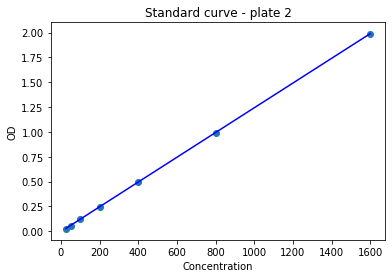

(array([-3.78793334e-03,  9.98603953e-01,  3.66448131e+06,  4.51679584e+03]), 2)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


,R^2,A,B,C,D
0,0.999996,-0.003788,0.998604,3.664481e+06,4516.795843


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


(array([-4.76984365e-04,  1.02365750e+00,  3.22089902e+06,  4.39217806e+03]), 3)


Plate: 3
********
(array([-4.76984365e-04,  1.02365750e+00,  3.22089902e+06,  4.39217806e+03]), 3)


,1,2,3,4,5,6,7,8,9,10,11,12
A,1607.687605,1592.924069,9856.174674,10620.697298,9476.160185,7890.364580,13128.716116,473.636899,606.627996,21363.846178,19274.491556,12011.874518
B,782.938312,815.035251,13882.904113,9274.679281,11123.327260,9205.370600,8867.810216,804.806464,477.095468,2302.106023,19343.254709,19318.861364
C,396.012858,404.079156,15166.760731,12738.382530,9947.267044,9714.524888,10769.652421,8573.093232,847.543781,2024.509218,1060.948061,21205.537194
D,206.136967,197.309211,8305.531081,13328.837750,14575.561748,10028.050586,11203.697622,10033.290507,8457.414515,2154.825408,1123.191539,382.468252
E,101.562434,98.082160,9556.716947,7490.752284,15645.327231,14409.651009,11777.145312,11585.272525,10490.043166,8261.607388,1272.470197,404.333459
F,49.449269,50.194084,10419.489248,9095.712296,8235.767422,14288.452695,17627.902401,10856.662115,10298.720437,9891.663250,8455.865002,525.538531
G,23.645183,24.876276,7719.086586,10036.939265,9830.491319,9357.652590,21264.906322,16324.592506,10995.305961,10016.795619,9939.950593,7063.161850
H,0.085301,0.918595,9421.372392,7915.712633,10540.224985,11844.755419,444.556242,18489.969286,17078.254382,10920.854044,10781.598815,7540.832150


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


(array([-4.76984365e-04,  1.02365750e+00,  3.22089902e+06,  4.39217806e+03]), 3)


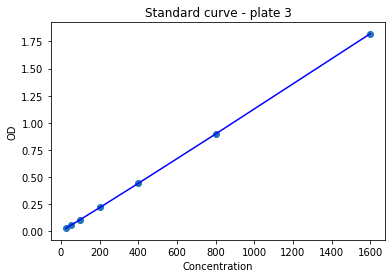

(array([-4.76984365e-04,  1.02365750e+00,  3.22089902e+06,  4.39217806e+03]), 3)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


,R^2,A,B,C,D
0,0.999998,-0.000477,1.023658,3.220899e+06,4392.178055


In [10]:
'''
This block do the following:
1.iterate over the sheets of the ELISA tamplet excel files, according to the number of plates
  specified by the user in the first block of code of the program. 
2. display a DataFrame of calculated concentration of each plate analyzed, and the details of the 
   standard curve, and create+save figure of standard curves. 
3. Creates lists, according to data type (raw OD data, concentration ect.), and to each list append the dataframes 
   of all plates with the same data type in the same list. These lists will serve for exporting the data to excel.  
'''

# Creating empty list for data frames:
list_std_dfs = list()
list_sample_dfs = list()
list_sample_MinusBlank_dfs = list()
list_sample_dil_dfs = list()
list_error_dfs = list()
list_std_curve_details_dfs = list()
list_std_conc_od_dfs = list()
list_conc_dfs = list()
list_sample_conc_minus_error_dfs = list()

# Iterating over the sheets of the ELISA tamplet excel according to the number of plates specified:
for plate in range(1,plate_num+1):   
    #Generating the DataFrames from the excel tamplet file, and assigning them to variables:
    std_OD_df, std_conc_df, sample_df, sample_MinusBlank_df, sample_dil_df, error_df = stdOD_sampleOD_dil_error_df_generator(file_name, plate)
    
    #generating the concentration and OD DataFrame of standard curve:
    std_conc_od_df = std_curve_df_generator(std_OD_df, high_std, dil_factor)

    #Fitting a 4PL regression model (standard curve fit):
    std_curve_curvefit_4PL(std_conc_od_df)

    # Calculating and displaying the concentration of samples: 
    print("\n\nPlate:",plate)
    print("*"*len("Plate: x"))
    sample_concentration_predict_df = sample_concentration_predict(std_curve_curvefit_4PL(std_conc_od_df), sample_MinusBlank_df)
    sample_concentration_predict_df.index = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    display(sample_concentration_predict_df)
    
    # Changing the index to letters A-H: 
    std_OD_df.index = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    sample_df.index = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    sample_MinusBlank_df.index = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    sample_dil_df.index = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'] 
    error_df.index = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    
    #Creating a DataFrame of sample concentrations without the error values (below or above std curve range):
    sample_conc_minus_error_df = sample_concentration_predict_df[error_df=="-"]

    #printing model details:
    #display(std_curve_curvefit_4PL(std_conc_od_df)[0])
    std_curve_4PL_vis(std_curve_curvefit_4PL(std_conc_od_df),plate)
    std_curve_details_df = std_curve_4PL_details(std_curve_curvefit_4PL(std_conc_od_df))
    display(std_curve_details_df)
    #display(sample_conc_minus_error_df)
    
    # Appending the DataFrames to the appropriate list: 
    list_std_dfs.append(std_OD_df)
    list_sample_dfs.append(sample_df)
    list_sample_MinusBlank_dfs.append(sample_MinusBlank_df)
    list_sample_dil_dfs.append(sample_dil_df)
    list_error_dfs.append(error_df)
    list_std_curve_details_dfs.append(std_curve_details_df)
    list_conc_dfs.append(sample_concentration_predict_df)
    list_std_conc_od_dfs.append(std_conc_od_df)
    list_sample_conc_minus_error_dfs.append(sample_conc_minus_error_df)
      
    plate+=1  
    

### Export the concentration, ODs and std curve DataFrames to excel 

In [11]:
from pandas import ExcelWriter
from pandas import ExcelFile

In [12]:
'''
This function generate titles that corresponde to the number of DataFrames in the argument list_dfs.
These titles will be used in exported output excel file in the end of the program as titles of 
calculated concentration dfs of the plates analyzed. 
The titles are generated by converting a string ("title_df{}") into a variable and assigning an empty DataFrame that 
contain only on column ("Plate {} - calculated concentrations"). 
These variables are then appended to a list (title_list). At the end of the for loop, the title_list contain all the 
titles, corresponding to number of plates analyzed. 
'''
def title_generator(list_dfs):
    title_list = list()
    for n in range(len(list_dfs)):
        x = globals()["title_df{}".format(n+1)] = pd.DataFrame(columns=["Plate {}".format(n+1)])     
        title_list.append(x)
    return title_list

title_list = title_generator(list_conc_dfs)

# for l in title_list:
#         display(l)

In [13]:
'''
This function insert several DataFrames in the same sheet from a list of DFs (list_dfs).
The function create an excel file (xls_path), and override an exsisting file with similar name.
'''
def save_xls(list_dfs, xls_path, title_list, sheet_name):
    i=0
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            title_list[n].to_excel(writer, sheet_name=sheet_name, startrow=i, startcol=0)
            df.to_excel(writer, sheet_name=sheet_name, startrow=i+1)
            i+=12
            #df.to_excel(writer,'Plate %s' % (n+1))
        writer.save()

In [14]:
'''
This function append DataFrames from a list of DFs (list_conc_dfs), to an excisting file (xls_path).
Each DataFrame is appended to a different sheet. 
The function wont work if the excel file does not exsist.
The appending mode is attributed to the mode='a' arguments in the ExcelWriter() and the engine='openpyxl 
(it doesn't work with the defult xlswriter engine).   
'''
def append_xls(list_dfs, xls_path, title_list, sheet_name):
    i=0
    with ExcelWriter(xls_path, mode='a', engine='openpyxl') as writer:
        for n, df in enumerate(list_dfs):
            title_list[n].to_excel(writer, sheet_name=sheet_name, startrow=i, startcol=0)
            df.to_excel(writer, sheet_name=sheet_name, startrow=i+1)
            i+=12
            #df.to_excel(writer,'Plate %s' % (n+1))
        writer.save()    

In [15]:
'''
This function append DataFrames from a list of DFs (list_conc_dfs), to an excisting file (xls_path).
Each DataFrame is appended to a different sheet. 
The function wont work if the excel file does not exsist.
The appending mode is attributed to the mode='a' arguments in the ExcelWriter() and the engine='openpyxl 
(it doesn't work with the defult xlswriter engine).   
'''
def append_xls2(list_dfs1, list_dfs2, xls_path, title_list, sheet_name):
    i=0
    with ExcelWriter(xls_path, mode='a', engine='openpyxl') as writer:
        for n, df in enumerate(list_dfs1):
            title_list[n].to_excel(writer, sheet_name=sheet_name, startrow=i)
            list_dfs1[n].to_excel(writer, sheet_name=sheet_name, startrow=i+1,startcol=1, index=False)
            list_dfs2[n].to_excel(writer, sheet_name=sheet_name, startrow=i+4,startcol=1, index=False)
            i+=15
            #df.to_excel(writer,'Plate %s' % (n+1))
        writer.save() 

In [16]:
xls_path = "ELISA_4PL_Analysis_Report.xlsx"

save_xls(list_conc_dfs, xls_path, title_list, 'Calculated concetrations')

append_xls(list_error_dfs, xls_path, title_list, "Errors (ODs outside std range)")
append_xls(list_sample_conc_minus_error_dfs, xls_path, title_list, "Concentration w_o errors")
append_xls(list_sample_dfs, xls_path, title_list, "Sample OD - raw data")
append_xls(list_sample_MinusBlank_dfs, xls_path, title_list, "Sample OD minus blank")
append_xls(list_sample_dil_dfs, xls_path, title_list, "Sample dilution factors")

append_xls2(list_std_curve_details_dfs, list_std_conc_od_dfs, xls_path, title_list, "Std curve details")